## Neural Networks: Non-Binary Classification

In this notebook, we will look at how to code a neural network for a classification problem with more than two classes.

This code is very similar to our previous notebook, where we coded a neural network for binary classification. In fact, all the hyperparameters you can tune in the previous example, you can tune here as well. However, there are several key differences, and all of them are highlighted in this notebook.

In [207]:
#!pip install torch

In [208]:
import numpy as np
import pandas as pd
import seaborn as sns # for plotting

# various PyTorch things for NNs
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split, DataLoader

# if you want reproducability, set random seeds:
# np.random.seed(42)
# torch.manual_seed(42)

In [209]:
df = pd.read_csv('topic3-spiral.csv')

def new_arms(row):
    if row['arm'] == 0:
        if row['x']**2 + row['y']**2 < 1:
            return 0
        else:
            return 1
    else:
        if row['x']**2 + row['y']**2 < 1:
            return 2
        else:
            return 3

df['arm'] = df.apply(new_arms, axis=1)
df.iloc[:5]

,x,y,arm
0,0.361659,-1.815359,1
1,-0.080207,0.467795,0
2,-1.236511,-0.940904,1
3,-0.568537,0.013438,0
4,-0.004653,-0.019253,0


<Axes: xlabel='x', ylabel='y'>

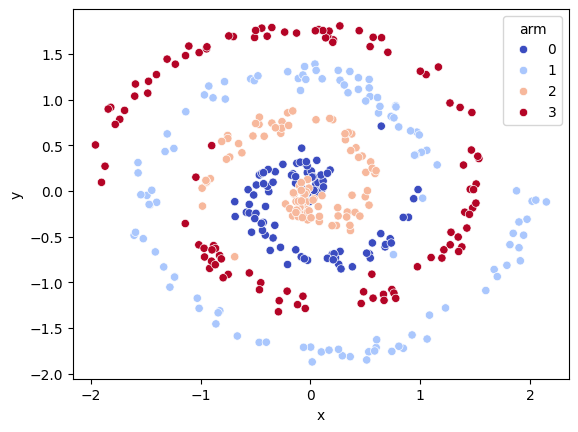

In [210]:
sns.scatterplot(data=df, x='x', y='y', hue='arm', palette="coolwarm")

**Change #1:** When defining the model architecture, ensure that the ouput layer contains the same number of neurons as you have groups in your target variable.

**Change #2:** Also, use the `softmax` activation function instead of the `sigmoid` function. The sigmoid function ensures that the final output will be between 0 and 1, which works as a probability for binary classification. For multi-class classification, you not only need to ensure the outputs are probabilities between 0 and 1, but also that they sum to 1. Softmax ensures this occurs.

**Change #3:** We will use a new loss function. This is how the neural network decided how good or bad a model performs. Don't worry about the math behind it (it's very advanced), but we used Binary Cross Entropy for a binary problem, and now we use Cross Entropy for a non-binary problem.

In [211]:
# Define the model architecture
class NNModelAdam(nn.Module):
    def __init__(self, dropout_rate=0):
        super(NNModelAdam, self).__init__()
        self.fc1 = nn.Linear(2, 8) # input has 2 neurons ('x' and 'y'), hidden layer 1 has 8 neurons
        self.fc2 = nn.Linear(8, 8) # hidden layer 1 has 8 neurons, hidden layer 2 has 8 neurons
        self.fc3 = nn.Linear(8, 4) # hidden layer 2 has 8 neurons, hidden layer 3 has 4 neurons
        self.fc4 = nn.Linear(4, 4) # hidden layer 3 has 4 neurons, output layer has 4 neurons (probabilities)
        self.dropout = nn.Dropout(dropout_rate)  # dropout with the default rate specified above

    def forward(self, x):
        x = F.relu(self.fc1(x)) # use ReLU activation function on hidden layer 1
        x = self.dropout(x) # dropout neurons in hidden layer 1
        x = F.relu(self.fc2(x)) # use ReLU activation function on hidden layer 2
        x = self.dropout(x) # dropout neurons in hidden layer 2
        x = F.relu(self.fc3(x)) # use ReLU activation function on hidden layer 3
        x = self.dropout(x) # dropout neurons in hidden layer 3
        x = torch.softmax(self.fc4(x), dim=1) # use softmax on output layer for non-binary classification to ensure range all probabilities sum to 1
        return x

# Instantiate the model
model = NNModelAdam()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # new loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.01) # make updates with a learning rate of 0.01

**Change #4:** We change the data format of y slightly. This code creates a 1D tensor (shape [n]) compared to a 2D tensor from before (shape [n,1]). This a subtle difference, but it's necessary for being compatible with the Cross Entropy loss function.

In [212]:
# Prepare data
X = torch.tensor(np.stack([df['x'], df['y']], axis=1), dtype=torch.float32)
y = torch.tensor(df['arm'].values, dtype=torch.long) # use a different data shape
dataset = TensorDataset(X, y)

train_ds, val_ds = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_dl = DataLoader(train_ds, batch_size=50, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=50)

**Change #5:** We need to extract the class with the greatest probability as our predicted class, as opposed to extracting the probability itself, in order to calculate accuracy.

In [213]:
num_epochs = 100

# Training loop with accuracy
for epoch in range(num_epochs):
    def run_epoch(dataloader, training=True):
        model.train() if training else model.eval()
        total_loss, correct, total_samples = [], 0, 0

        for xb, yb in dataloader:
            preds = model(xb)  # raw logits of shape (batch_size, 4)
            loss = criterion(preds, yb)  # yb should be LongTensor with class indices (0-3)

            if training:
                optimizer.zero_grad() # set gradients to zero to begin
                loss.backward() # perform backpropogation to set the gradients
                optimizer.step() # take a step (aka update the weights and biases)

            total_loss += [loss.item()]

            # Predictions: choose class with highest score (argmax)
            predicted = torch.argmax(preds, dim=1)
            correct += (predicted == yb).sum().item()
            total_samples += yb.size(0)

        avg_loss = np.mean(total_loss)
        accuracy = correct / total_samples
        return avg_loss, accuracy

    train_loss, train_acc = run_epoch(train_dl, training=True)
    val_loss, val_acc = run_epoch(val_dl, training=False)

    print(f"Epoch {epoch+1:3d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

Epoch   1 | Train Loss: 1.3892 | Train Acc: 23.44% | Val Loss: 1.3731 | Val Acc: 28.75%
Epoch   2 | Train Loss: 1.3800 | Train Acc: 28.44% | Val Loss: 1.3659 | Val Acc: 26.25%
Epoch   3 | Train Loss: 1.3724 | Train Acc: 29.06% | Val Loss: 1.3590 | Val Acc: 26.25%
Epoch   4 | Train Loss: 1.3641 | Train Acc: 30.63% | Val Loss: 1.3488 | Val Acc: 28.75%
Epoch   5 | Train Loss: 1.3422 | Train Acc: 32.19% | Val Loss: 1.3419 | Val Acc: 25.00%
Epoch   6 | Train Loss: 1.3294 | Train Acc: 30.00% | Val Loss: 1.3404 | Val Acc: 25.00%
Epoch   7 | Train Loss: 1.3243 | Train Acc: 30.63% | Val Loss: 1.3387 | Val Acc: 26.25%
Epoch   8 | Train Loss: 1.3105 | Train Acc: 31.25% | Val Loss: 1.3297 | Val Acc: 25.00%
Epoch   9 | Train Loss: 1.2931 | Train Acc: 30.63% | Val Loss: 1.3218 | Val Acc: 25.00%
Epoch  10 | Train Loss: 1.2907 | Train Acc: 31.87% | Val Loss: 1.3097 | Val Acc: 28.75%
Epoch  11 | Train Loss: 1.2721 | Train Acc: 43.75% | Val Loss: 1.2981 | Val Acc: 40.00%
Epoch  12 | Train Loss: 1.2655 |

**Change #6:** Again, we need to extract the class with the highest predicted probability. Then, we can plot based on this predicted class instead of the predicted probability.

Val Acc: 67.50%


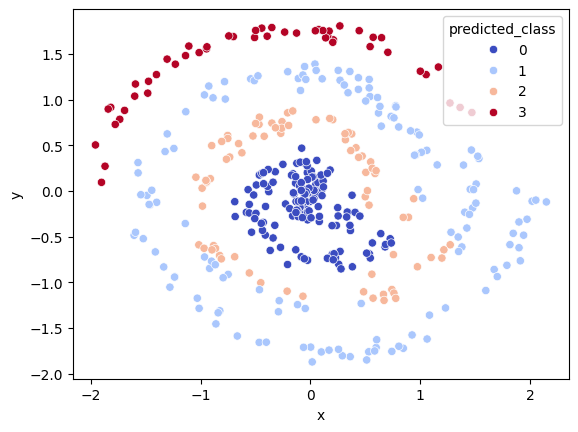

In [214]:
# Make sure the model is in evaluation mode
model.eval()

# Prepare the input data from the dataframe
inputs = torch.tensor(df[['x', 'y']].values, dtype=torch.float32)

# Get predictions
with torch.no_grad():
    logits = model(inputs)  # raw outputs (logits)
    predicted_class = torch.argmax(logits, dim=1)  # pick the class with the highest logit

# Add the predicted class as a new column
df['predicted_class'] = predicted_class.numpy()

# Visualize the predicted classes
sns.scatterplot(data=df, x='x', y='y', hue='predicted_class', palette='coolwarm')  # or any bold palette
print(f"Val Acc: {val_acc:.2%}")

As a reminder, here are the **hyperparameters** you can tune to try and improve your Neural Network. 

Play around with any and all of these to see what seems to work best!

- Number of hidden layers in the NN
- Number of neurons in each layer of the NN
- Activation function at each layer in the NN
- Whether or not you need regularization (dropout) to mitigate overfitting
- If so, what proportion of neurons should you drop out after each layer?
- Number of epochs
- Batch size
- Learning rate